In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
import math,random
torch.__version__

'1.0.1.post2'

In [2]:
TIME_STEP=10 # rnn 时序步长数
INPUT_SIZE=1 # rnn 的输入维度
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
H_SIZE=64 # of rnn 隐藏单元个数
EPOCHS=300 # 总训练次数
h_state=None # 隐藏层的状态

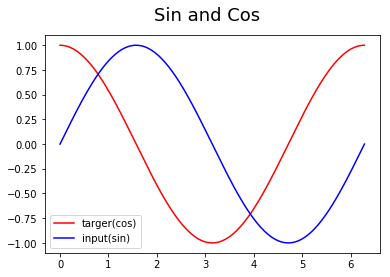

In [4]:
steps=np.linspace(0,np.pi*2,256,dtype=np.float32)
x_np=np.sin(steps)
y_np=np.cos(steps)
plt.figure(1)
plt.suptitle('Sin and Cos',fontsize='18')
plt.plot(steps,y_np,'r-',label='targer(cos)')
plt.plot(steps,x_np,'b-',label='input(sin)')
plt.legend(loc='best')
plt.show()

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.rnn=nn.RNN(
            input_size=INPUT_SIZE,
        hidden_size=H_SIZE,
        num_layers=1,
        batch_first=True)
        self.out=nn.Linear(H_SIZE,1)
    def forward(self,x,h_state):
        # x (batch,time_step,input_size)
        # h_state(n_layers,batch,hidden_size)
        # r_out(batch,time_step,hidden_size)
        r_out,h_state=self.rnn(x,h_state)
        outs=[] # 保存所有的预测值
        for time_step in range(r_out.size(1)):
            #计算每一步长的预测值
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1),h_state
        # 也可以用以下这样的返回值
        # r_out=r_out.view(-1,32)
        # outs=self.out(r_out)
        # return outs,h_state

In [4]:
rnn=RNN().to(DEVICE)
optimizer=torch.optim.Adam(rnn.parameters()) #Adam优化，几乎不用调参
criterion=nn.MSELoss() # 因为最终的结果是一个数，所以损失函数使用均方误差

EPOCHS: 19,loss:0.013962


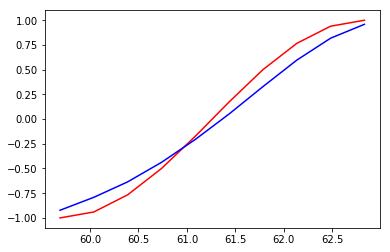

EPOCHS: 39,loss:0.007956


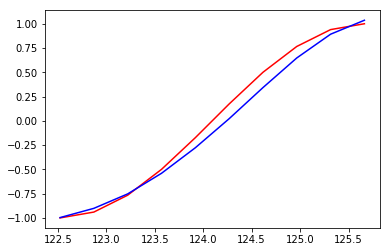

EPOCHS: 59,loss:0.005107


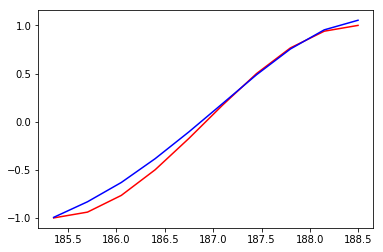

EPOCHS: 79,loss:0.002420


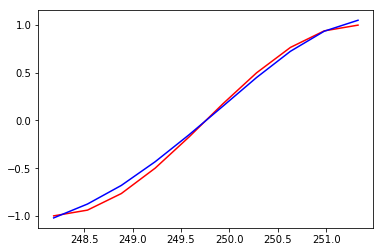

EPOCHS: 99,loss:0.002417


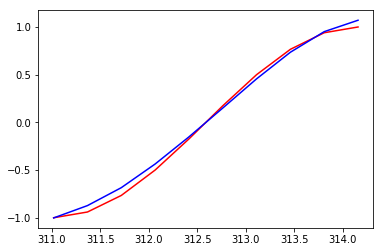

EPOCHS: 119,loss:0.436035


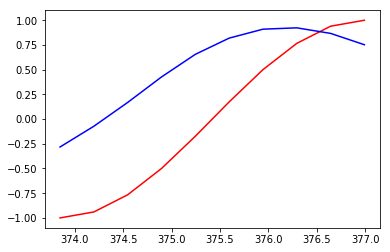

EPOCHS: 139,loss:0.043929


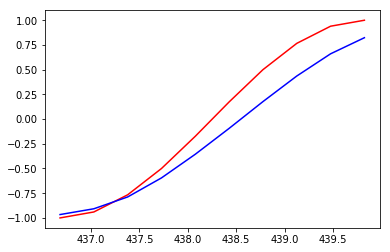

EPOCHS: 159,loss:0.012205


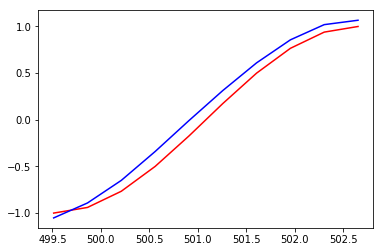

EPOCHS: 179,loss:0.002255


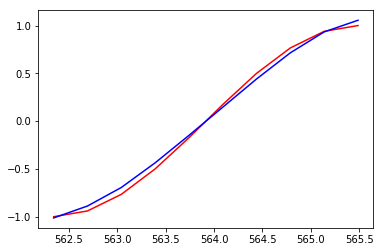

EPOCHS: 199,loss:0.002472


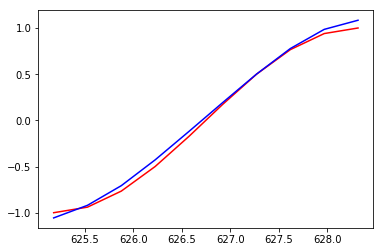

EPOCHS: 219,loss:0.001815


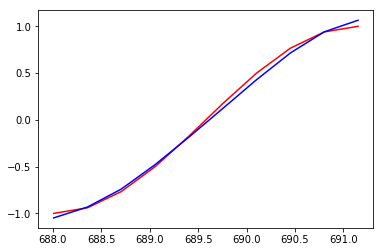

EPOCHS: 239,loss:0.001470


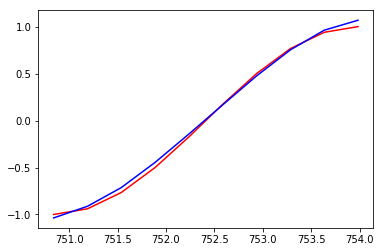

EPOCHS: 259,loss:0.001121


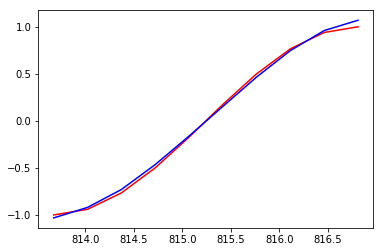

EPOCHS: 279,loss:0.001071


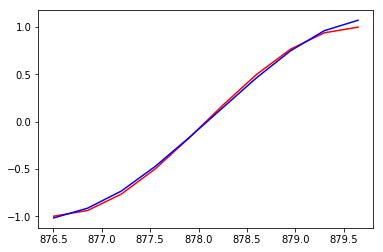

EPOCHS: 299,loss:0.001180


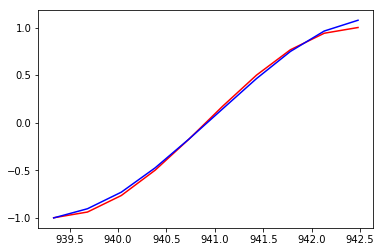

In [8]:
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start,end=step*np.pi,(step+1)*np.pi  # 一个时间周期
    steps=np.linspace(start,end,TIME_STEP,dtype=np.float32)
    x_np=np.sin(steps)
    y_np=np.cos(steps)
    x=torch.from_numpy(x_np[np.newaxis,:,np.newaxis]) # shape(batch,time_step,input_size)
    y=torch.from_numpy(y_np[np.newaxis,:,np.newaxis]) # np.newaxis 在使用和功能上等价于 None
    x,y=x.to(DEVICE),y.to(DEVICE)
    prediction,h_state=rnn(x,h_state) # rnn output
    # 特别重要
    h_state=h_state.data #重置隐藏层的状态，切断和前一次迭代的连接
    loss=criterion(prediction,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(step+1)%20==0:
        # 每训练营0个批次可视化一下效果，并打印一下
        print("EPOCHS: {},loss:{:4f}".format(step,loss))
        plt.plot(steps,y_np.flatten(),'r-')
        plt.plot(steps,prediction.data.cpu().numpy().flatten(),'b-')
        # cuda不能直接到numpy，需要先转到cpu
        plt.draw()
        plt.pause(0.01)